本教程介绍单词嵌入。它包含完整的代码，可从头训练一个小的数据集上的单词嵌入，并使用Embedding Projector（如下图所示）可视化这些嵌入。

<img src="embedding.jpg"  height="330" width="495">

用数字表示文本<br>
机器学习模型将向量（数字数组）作为输入。在处理文本时，我们首先要做的是在将字符串输入模型之前将字符串转换为数字（或“向量化”文本）的策略。在本节中，我们将研究这样做的三种策略。

一键编码<br>
作为第一个想法，我们可以“单语”对词汇表中的每个单词进行编码。考虑一句“猫坐在垫子上”。这句话中的词汇（或独特词）是（猫，猫，猫，猫，猫）。为了表示每个单词，我们将创建一个零矢量，其长度等于词汇量，然后在与该单词对应的索引中放置一个。下图显示了这种方法。

<img src="one-hot.png"  height="330" width="495">

为了创建一个包含句子编码的矢量，我们可以将每个单词的单热矢量连接起来。

关键点：这种方法效率低下。一个热编码的向量是稀疏的（意味着，大多数索引为零）。想象一下，我们的词汇表中有10,000个单词。为了对每个单词进行一次热编码，我们将创建一个向量，其中99.99％的元素为零。

用一个唯一的数字编码每个单词<br>
我们可能尝试的第二种方法是使用唯一数字对每个单词进行编码。继续上面的示例，我们可以将1分配给“ cat”，将2分配给“ mat”，依此类推。然后，我们可以将句子“猫坐在垫子上”编码为一个密集的向量，例如[5，1，4，3，5，2]。这种方法是有效的。现在，我们有了一个密集的矢量（所有元素都已满），而不是稀疏的矢量。

但是，此方法有两个缺点：
* 整数编码是任意的（它不捕获单词之间的任何关系）。

* 对于模型来说，整数编码可能是一个挑战。例如，线性分类器为每个特征学习单个权重。因为任何两个单词的相似性与其编码的相似性之间都没有关系，所以这种特征权重组合是没有意义的。

词嵌入<br>
单词嵌入为我们提供了一种使用高效密集表示的方式，其中相似的单词具有相似的编码。重要的是，我们不必手动指定此编码。嵌入是浮点值的密集向量（向量的长度是您指定的参数）。它们不是可手动指定嵌入值的值，而是可训练的参数（模型在训练过程中学习的权重，就像模型学习密集层的权重一样）。通常会看到8维（对于小型数据集）的单词嵌入，在处理大型数据集时，最大可达1024维。更高维的嵌入可以捕获单词之间的细粒度关系，但需要更多的数据来学习。

<img src="embedding2.png"  height="330" width="495">

上面是单词嵌入的示意图。每个单词都表示为浮点值的4维向量。考虑嵌入的另一种方法是“查找表”。了解了这些权重后，我们可以通过在表中查找对应的密集矢量来对每个单词进行编码。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

使用嵌入层<br>
Keras使单词嵌入易于使用。让我们看一下嵌入层。

嵌入层可以理解为一个查找表，它从整数索引（代表特定单词）映射到密集向量（其嵌入）。嵌入的维数（或宽度）是您可以进行实验的参数，以查看哪种方法可以很好地解决您的问题，这与您对密集层中的神经元数量进行实验的方式非常相似。

In [3]:
embedding_layer = layers.Embedding(1000, 5)

创建嵌入层时，嵌入的权重会随机初始化（就像其他任何层一样）。在训练过程中，通过反向传播逐渐调整它们。训练后，学习到的词嵌入将大致编码词之间的相似性（因为它们是针对训练模型的特定问题而学习的）。

如果将整数传递给嵌入层，则结果将使用嵌入表中的向量替换每个整数：

In [4]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03230766, -0.04893189, -0.01771693,  0.00407945, -0.0177909 ],
       [-0.002322  ,  0.01774111,  0.01127191,  0.03834495,  0.02816475],
       [ 0.04879446, -0.03597724,  0.01682862, -0.04756141,  0.02020696]],
      dtype=float32)

对于文本或序列问题，Embedding层采用2D整数张量，形状为(samples, sequence_length)，其中每个条目都是一个整数序列。它可以嵌入可变长度的序列。您可以将具有形状(32, 10)（批处理长度为32的序列的(64, 15)批处理）或（批处理长度为15的64序列的批处理）的批处理放入嵌入层中。

返回的张量的轴多于输入的轴，嵌入矢量沿新的最后一个轴对齐。将其传递给(2, 3)输入批次，输出为(2, 3, N)

In [5]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

当给定一批序列作为输入时，嵌入层将返回一个shape的3D浮点张量(samples, sequence_length, embedding_dimensionality)。为了从可变长度的序列转换成固定的表示形式，有多种标准方法。您可以在将RNN，Attention或池化层传递到Dense层之前使用它。本教程使用池，因为它最简单。带有RNN教程的文本分类是不错的下一步。

从零开始学习嵌入<br>
在本教程中，您将训练有关IMDB电影评论的情感分类器。在此过程中，模型将从头开始学习嵌入。我们将使用预处理数据集。

要从头开始加载文本数据集，请参阅“ 加载文本教程”。

In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

获取编码器（tfds.features.text.SubwordTextEncoder），并快速浏览词汇表。

词汇表中的“ _”代表空格。请注意，词汇表如何包含整个单词（以“ _”结尾）和部分单词，可用于构建更大的单词：

In [7]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

电影评论的长度可以不同。我们将使用该padded_batch方法来规范评论的长度。

In [8]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

导入时，评论文本是整数编码的（每个整数代表词汇中的特定单词或单词部分）。

请注意尾随零，因为批处理将填充到最长的示例中。

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  19,  213,  250, ...,    0,    0,    0],
       [1419,  143,  121, ...,   35,  835, 7975],
       [  12,  284,   14, ...,    0,    0,    0],
       ...,
       [6172,    8,    7, ...,    0,    0,    0],
       [1379,  829,  106, ...,    0,    0,    0],
       [ 156,   37,   52, ...,    0,    0,    0]], dtype=int64)

创建一个简单的模型<br>
我们将使用Keras顺序API定义模型。在这种情况下，它是“连续单词袋”样式模型。

接下来，嵌入层采用整数编码的词汇表，并为每个单词索引查找嵌入向量。这些向量是在模型训练中学习的。向量将维度添加到输出数组。产生的尺寸为：(batch, sequence, embedding)。

接下来，GlobalAveragePooling1D层通过对序列维进行平均，为每个示例返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。

该固定长度的输出矢量通过16个隐藏单元的完全连接（密集）层进行管道传输。

最后一层与单个输出节点紧密连接。使用S形激活函数，此值是0到1之间的浮点数，表示评论为肯定的概率（或置信度）。

警告：此模型不使用屏蔽，因此零填充用作输入的一部分，因此填充长度可能会影响输出。要解决此问题，请参见掩蔽和填充指南。

In [21]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


编译和训练模型

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


    174/Unknown - 1s 1s/step - loss: 0.6962 - accuracy: 0.40 - 1s 532ms/step - loss: 0.6951 - accuracy: 0.400 - 1s 358ms/step - loss: 0.6947 - accuracy: 0.400 - 1s 271ms/step - loss: 0.6939 - accuracy: 0.450 - 1s 218ms/step - loss: 0.6941 - accuracy: 0.440 - 1s 184ms/step - loss: 0.6946 - accuracy: 0.416 - 1s 159ms/step - loss: 0.6937 - accuracy: 0.428 - 1s 140ms/step - loss: 0.6938 - accuracy: 0.425 - 1s 125ms/step - loss: 0.6941 - accuracy: 0.433 - 1s 114ms/step - loss: 0.6935 - accuracy: 0.460 - 1s 104ms/step - loss: 0.6936 - accuracy: 0.454 - 1s 96ms/step - loss: 0.6937 - accuracy: 0.458 - 1s 89ms/step - loss: 0.6938 - accuracy: 0.44 - 1s 83ms/step - loss: 0.6936 - accuracy: 0.47 - 1s 78ms/step - loss: 0.6935 - accuracy: 0.48 - 1s 74ms/step - loss: 0.6934 - accuracy: 0.48 - 1s 70ms/step - loss: 0.6935 - accuracy: 0.47 - 1s 67ms/step - loss: 0.6935 - accuracy: 0.47 - 1s 64ms/step - loss: 0.6934 - accuracy: 0.47 - 1s 61ms/step - loss: 0.6934 - accuracy: 0.48 - 1s 59ms/step - loss: 0.

    696/Unknown - 5s 10ms/step - loss: 0.6896 - accuracy: 0.56 - 5s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6894 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6895 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6894 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6894 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6894 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6894 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6893 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6893 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6893 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6893 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6892 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6892 - accuracy: 0.56 - 6s 10ms/step - loss: 0.6892 - accuracy: 0.

    870/Unknown - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6869 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6867 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.58 - 7s 10ms/step - loss: 0.6868 - accuracy: 0.

   1044/Unknown - 8s 10ms/step - loss: 0.6841 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6841 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6840 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6840 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6840 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6840 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6840 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6839 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6838 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6838 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6838 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6837 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6837 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6837 - accuracy: 0.59 - 8s 10ms/step - loss: 0.6837 - accuracy: 0.59 - 9s 10ms/step - loss: 0.6837 - accuracy: 0.

   1218/Unknown - 10s 9ms/step - loss: 0.6804 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6804 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6804 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6803 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6803 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6803 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6802 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6802 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6802 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6802 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6801 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6801 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6801 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6801 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6800 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6800 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6800 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6799 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6799 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6798 - accuracy: 0.61 - 10s 9ms/step - loss: 0.6798 - accuracy: 0.

   1392/Unknown - 11s 9ms/step - loss: 0.6755 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6755 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6754 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6754 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6754 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6754 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6753 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6752 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6751 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6751 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6751 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6750 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6750 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6750 - accuracy: 0.63 - 11s 9ms/step - loss: 0.6749 - accuracy: 0.

   1566/Unknown - 13s 9ms/step - loss: 0.6697 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6696 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6696 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6695 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6695 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6695 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6694 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6694 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6693 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6693 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6692 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6692 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6691 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6691 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6691 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6691 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6690 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6690 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6690 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6689 - accuracy: 0.64 - 13s 9ms/step - loss: 0.6689 - accuracy: 0.

   1740/Unknown - 14s 9ms/step - loss: 0.6636 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6636 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6636 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6636 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6635 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6634 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6634 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6633 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6633 - accuracy: 0.65 - 14s 9ms/step - loss: 0.6632 - accuracy: 0.

   1914/Unknown - 15s 9ms/step - loss: 0.6582 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6582 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6582 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6581 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6581 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6581 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6581 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6580 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6581 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6579 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6578 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6578 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6578 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6577 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6577 - accuracy: 0.66 - 16s 9ms/step - loss: 0.6577 - accuracy: 0.

   2088/Unknown - 17s 9ms/step - loss: 0.6522 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6522 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6521 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6521 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6521 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6520 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6520 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6520 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6520 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6519 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6519 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6519 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6518 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6518 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6518 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6518 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6517 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6516 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6517 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6517 - accuracy: 0.67 - 17s 9ms/step - loss: 0.6516 - accuracy: 0.

   2262/Unknown - 18s 9ms/step - loss: 0.6463 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6463 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6462 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6462 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6461 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6461 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6460 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6460 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6460 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6460 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6459 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6459 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6458 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6458 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6458 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6457 - accuracy: 0.68 - 18s 9ms/step - loss: 0.6457 - accuracy: 0.68 - 19s 9ms/step - loss: 0.6457 - accuracy: 0.68 - 19s 9ms/step - loss: 0.6456 - accuracy: 0.68 - 19s 9ms/step - loss: 0.6456 - accuracy: 0.68 - 19s 9ms/step - loss: 0.6455 - accuracy: 0.

   2436/Unknown - 20s 9ms/step - loss: 0.6392 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6392 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6391 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6391 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6390 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6389 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6388 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6388 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6388 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6388 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6387 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6387 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6387 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6386 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6386 - accuracy: 0.69 - 20s 9ms/step - loss: 0.6386 - accuracy: 0.

2500/2500 [==============================]327 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6327 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6327 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6327 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6326 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6326 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6325 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6325 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6325 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6324 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6323 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6324 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6323 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6323 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6323 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6322 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6322 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6322 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6322 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6321 - accuracy: 0.69 - 21s 9ms/step - loss: 0.6321 - accuracy: 0.

2015/2500 [=======================>......] - ETA: 4:04 - loss: 0.2478 - accuracy: 0.90 - ETA: 33s - loss: 0.4329 - accuracy: 0.8182 - ETA: 22s - loss: 0.4147 - accuracy: 0.831 - ETA: 19s - loss: 0.4099 - accuracy: 0.839 - ETA: 17s - loss: 0.4035 - accuracy: 0.844 - ETA: 16s - loss: 0.4110 - accuracy: 0.845 - ETA: 15s - loss: 0.4150 - accuracy: 0.844 - ETA: 15s - loss: 0.4194 - accuracy: 0.843 - ETA: 14s - loss: 0.4137 - accuracy: 0.847 - ETA: 14s - loss: 0.4046 - accuracy: 0.853 - ETA: 13s - loss: 0.4046 - accuracy: 0.854 - ETA: 13s - loss: 0.3998 - accuracy: 0.854 - ETA: 13s - loss: 0.4039 - accuracy: 0.852 - ETA: 13s - loss: 0.4044 - accuracy: 0.850 - ETA: 12s - loss: 0.4071 - accuracy: 0.846 - ETA: 12s - loss: 0.4064 - accuracy: 0.848 - ETA: 12s - loss: 0.4051 - accuracy: 0.851 - ETA: 12s - loss: 0.4009 - accuracy: 0.855 - ETA: 12s - loss: 0.3991 - accuracy: 0.855 - ETA: 12s - loss: 0.3992 - accuracy: 0.857 - ETA: 12s - loss: 0.4005 - accuracy: 0.857 - ETA: 12s - loss: 0.3997 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.3642 - accuracy: 0.87 - ETA: 2s - loss: 0.3641 - accuracy: 0.87 - ETA: 2s - loss: 0.3639 - accuracy: 0.87 - ETA: 2s - loss: 0.3641 - accuracy: 0.87 - ETA: 2s - loss: 0.3641 - accuracy: 0.87 - ETA: 2s - loss: 0.3645 - accuracy: 0.87 - ETA: 2s - loss: 0.3642 - accuracy: 0.87 - ETA: 2s - loss: 0.3643 - accuracy: 0.87 - ETA: 1s - loss: 0.3641 - accuracy: 0.87 - ETA: 1s - loss: 0.3641 - accuracy: 0.87 - ETA: 1s - loss: 0.3638 - accuracy: 0.87 - ETA: 1s - loss: 0.3641 - accuracy: 0.87 - ETA: 1s - loss: 0.3641 - accuracy: 0.87 - ETA: 1s - loss: 0.3637 - accuracy: 0.87 - ETA: 1s - loss: 0.3632 - accuracy: 0.87 - ETA: 1s - loss: 0.3628 - accuracy: 0.87 - ETA: 1s - loss: 0.3625 - accuracy: 0.87 - ETA: 1s - loss: 0.3622 - accuracy: 0.87 - ETA: 1s - loss: 0.3622 - accuracy: 0.87 - ETA: 1s - loss: 0.3615 - accuracy: 0.87 - ETA: 1s - loss: 0.3613 - accuracy: 0.87 - ETA: 1s - loss: 0.3612 - accuracy: 0.87 - ETA: 1s - loss: 0.3611 - accura

2048/2500 [=======================>......] - ETA: 3:56 - loss: 0.5350 - accuracy: 0.70 - ETA: 33s - loss: 0.2856 - accuracy: 0.9182 - ETA: 23s - loss: 0.2905 - accuracy: 0.895 - ETA: 19s - loss: 0.3208 - accuracy: 0.880 - ETA: 18s - loss: 0.3048 - accuracy: 0.885 - ETA: 16s - loss: 0.2967 - accuracy: 0.901 - ETA: 16s - loss: 0.3041 - accuracy: 0.891 - ETA: 15s - loss: 0.2857 - accuracy: 0.901 - ETA: 14s - loss: 0.2859 - accuracy: 0.901 - ETA: 14s - loss: 0.2840 - accuracy: 0.905 - ETA: 14s - loss: 0.2781 - accuracy: 0.907 - ETA: 13s - loss: 0.2907 - accuracy: 0.902 - ETA: 13s - loss: 0.2947 - accuracy: 0.900 - ETA: 13s - loss: 0.2937 - accuracy: 0.902 - ETA: 13s - loss: 0.2902 - accuracy: 0.902 - ETA: 13s - loss: 0.2886 - accuracy: 0.903 - ETA: 12s - loss: 0.2916 - accuracy: 0.901 - ETA: 12s - loss: 0.2913 - accuracy: 0.902 - ETA: 12s - loss: 0.2871 - accuracy: 0.904 - ETA: 12s - loss: 0.2903 - accuracy: 0.904 - ETA: 12s - loss: 0.2914 - accuracy: 0.904 - ETA: 12s - loss: 0.2909 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.2734 - accuracy: 0.90 - ETA: 2s - loss: 0.2734 - accuracy: 0.90 - ETA: 2s - loss: 0.2731 - accuracy: 0.90 - ETA: 2s - loss: 0.2733 - accuracy: 0.90 - ETA: 1s - loss: 0.2732 - accuracy: 0.90 - ETA: 1s - loss: 0.2731 - accuracy: 0.90 - ETA: 1s - loss: 0.2726 - accuracy: 0.90 - ETA: 1s - loss: 0.2724 - accuracy: 0.90 - ETA: 1s - loss: 0.2724 - accuracy: 0.90 - ETA: 1s - loss: 0.2724 - accuracy: 0.90 - ETA: 1s - loss: 0.2728 - accuracy: 0.90 - ETA: 1s - loss: 0.2726 - accuracy: 0.90 - ETA: 1s - loss: 0.2729 - accuracy: 0.90 - ETA: 1s - loss: 0.2730 - accuracy: 0.90 - ETA: 1s - loss: 0.2736 - accuracy: 0.90 - ETA: 1s - loss: 0.2742 - accuracy: 0.90 - ETA: 1s - loss: 0.2742 - accuracy: 0.90 - ETA: 1s - loss: 0.2741 - accuracy: 0.90 - ETA: 1s - loss: 0.2739 - accuracy: 0.90 - ETA: 1s - loss: 0.2739 - accuracy: 0.90 - ETA: 1s - loss: 0.2738 - accuracy: 0.90 - ETA: 1s - loss: 0.2739 - accuracy: 0.90 - ETA: 0s - loss: 0.2738 - accura

2001/2500 [=======================>......] - ETA: 4:19 - loss: 0.1399 - accuracy: 1.00 - ETA: 32s - loss: 0.2507 - accuracy: 0.9417 - ETA: 22s - loss: 0.2255 - accuracy: 0.934 - ETA: 19s - loss: 0.2408 - accuracy: 0.924 - ETA: 17s - loss: 0.2607 - accuracy: 0.922 - ETA: 16s - loss: 0.2904 - accuracy: 0.910 - ETA: 15s - loss: 0.2856 - accuracy: 0.909 - ETA: 15s - loss: 0.2812 - accuracy: 0.910 - ETA: 14s - loss: 0.2751 - accuracy: 0.912 - ETA: 14s - loss: 0.2669 - accuracy: 0.917 - ETA: 14s - loss: 0.2609 - accuracy: 0.920 - ETA: 13s - loss: 0.2603 - accuracy: 0.918 - ETA: 13s - loss: 0.2592 - accuracy: 0.918 - ETA: 13s - loss: 0.2559 - accuracy: 0.919 - ETA: 13s - loss: 0.2570 - accuracy: 0.918 - ETA: 12s - loss: 0.2529 - accuracy: 0.919 - ETA: 12s - loss: 0.2503 - accuracy: 0.921 - ETA: 12s - loss: 0.2502 - accuracy: 0.919 - ETA: 12s - loss: 0.2518 - accuracy: 0.919 - ETA: 12s - loss: 0.2507 - accuracy: 0.918 - ETA: 12s - loss: 0.2493 - accuracy: 0.919 - ETA: 12s - loss: 0.2440 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.2322 - accuracy: 0.92 - ETA: 2s - loss: 0.2324 - accuracy: 0.92 - ETA: 2s - loss: 0.2322 - accuracy: 0.92 - ETA: 2s - loss: 0.2320 - accuracy: 0.92 - ETA: 2s - loss: 0.2319 - accuracy: 0.92 - ETA: 2s - loss: 0.2317 - accuracy: 0.92 - ETA: 2s - loss: 0.2317 - accuracy: 0.92 - ETA: 2s - loss: 0.2315 - accuracy: 0.92 - ETA: 2s - loss: 0.2314 - accuracy: 0.92 - ETA: 1s - loss: 0.2319 - accuracy: 0.92 - ETA: 1s - loss: 0.2319 - accuracy: 0.92 - ETA: 1s - loss: 0.2322 - accuracy: 0.92 - ETA: 1s - loss: 0.2326 - accuracy: 0.92 - ETA: 1s - loss: 0.2323 - accuracy: 0.92 - ETA: 1s - loss: 0.2322 - accuracy: 0.92 - ETA: 1s - loss: 0.2320 - accuracy: 0.92 - ETA: 1s - loss: 0.2323 - accuracy: 0.92 - ETA: 1s - loss: 0.2322 - accuracy: 0.92 - ETA: 1s - loss: 0.2319 - accuracy: 0.92 - ETA: 1s - loss: 0.2316 - accuracy: 0.92 - ETA: 1s - loss: 0.2314 - accuracy: 0.92 - ETA: 1s - loss: 0.2312 - accuracy: 0.92 - ETA: 1s - loss: 0.2312 - accura

2078/2500 [=======================>......] - ETA: 4:11 - loss: 0.0606 - accuracy: 1.00 - ETA: 31s - loss: 0.2057 - accuracy: 0.9583 - ETA: 22s - loss: 0.1834 - accuracy: 0.956 - ETA: 18s - loss: 0.2059 - accuracy: 0.932 - ETA: 17s - loss: 0.2052 - accuracy: 0.924 - ETA: 15s - loss: 0.2020 - accuracy: 0.925 - ETA: 15s - loss: 0.2027 - accuracy: 0.927 - ETA: 14s - loss: 0.2104 - accuracy: 0.924 - ETA: 14s - loss: 0.2095 - accuracy: 0.922 - ETA: 13s - loss: 0.2145 - accuracy: 0.921 - ETA: 13s - loss: 0.2168 - accuracy: 0.919 - ETA: 13s - loss: 0.2155 - accuracy: 0.921 - ETA: 13s - loss: 0.2144 - accuracy: 0.921 - ETA: 13s - loss: 0.2127 - accuracy: 0.924 - ETA: 13s - loss: 0.2107 - accuracy: 0.926 - ETA: 12s - loss: 0.2066 - accuracy: 0.928 - ETA: 12s - loss: 0.2055 - accuracy: 0.930 - ETA: 12s - loss: 0.2078 - accuracy: 0.929 - ETA: 12s - loss: 0.2072 - accuracy: 0.931 - ETA: 12s - loss: 0.2079 - accuracy: 0.929 - ETA: 12s - loss: 0.2066 - accuracy: 0.930 - ETA: 12s - loss: 0.2065 - accu

2500/2500 [==============================] - ETA: 2s - loss: 0.2005 - accuracy: 0.93 - ETA: 1s - loss: 0.2009 - accuracy: 0.93 - ETA: 1s - loss: 0.2015 - accuracy: 0.93 - ETA: 1s - loss: 0.2018 - accuracy: 0.93 - ETA: 1s - loss: 0.2018 - accuracy: 0.93 - ETA: 1s - loss: 0.2016 - accuracy: 0.93 - ETA: 1s - loss: 0.2012 - accuracy: 0.93 - ETA: 1s - loss: 0.2011 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2005 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 1s - loss: 0.2005 - accuracy: 0.93 - ETA: 1s - loss: 0.2006 - accuracy: 0.93 - ETA: 1s - loss: 0.2007 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.2008 - accura

In [14]:
%matplotlib inline

通过这种方法，我们的模型可以达到约88％的验证准确度（请注意，该模型过于拟合，训练准确度要高得多）

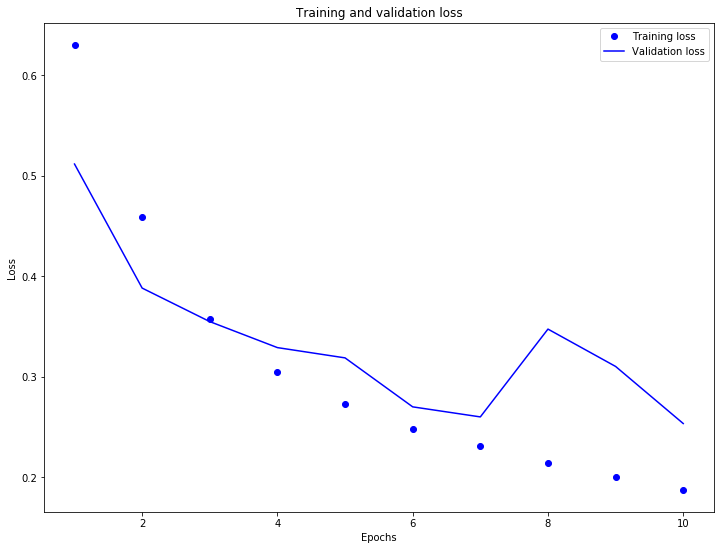

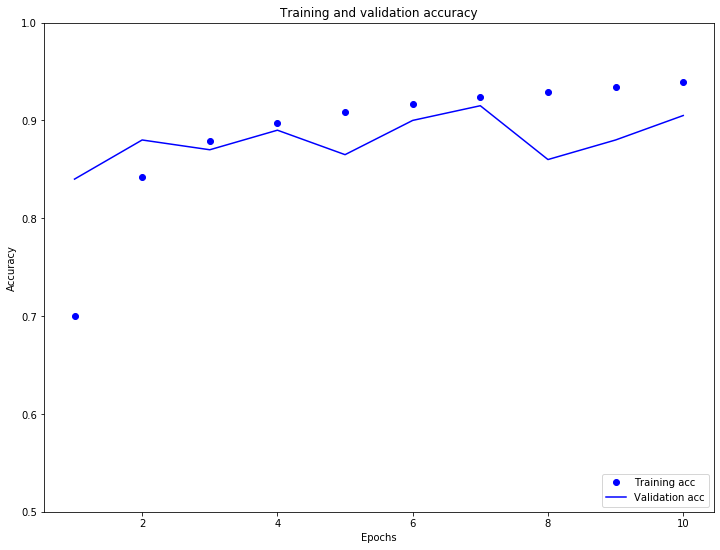

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

检索学习的嵌入<br>
接下来，让我们检索在训练中学习的词嵌入。这将是形状矩阵(vocab_size, embedding-dimension)。

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


现在，我们将权重写入磁盘。要使用Embedding Projector，我们将以制表符分隔的格式上传两个文件：一个向量文件（包含嵌入）和一个元数据文件（包含单词）。

In [17]:
encoder = info.features['text'].encoder

In [18]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

如果您正在Colaboratory中运行本教程，则可以使用以下代码片段将这些文件下载到本地计算机（或使用文件浏览器，查看->目录->文件浏览器）。

In [ ]:
# try:
#     from google.colab import files
# except ImportError:
#      pass
# else:
#     files.download('vecs.tsv')
#     files.download('meta.tsv')

## 使用屏蔽,填充不作为输入的一部分

In [28]:
embedding_dim=16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim,mask_zero=True),
    layers.LSTM(16),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          130960    
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 133,089
Trainable params: 133,089
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20,verbose=2)

Epoch 1/10
2500/2500 - 89s - loss: 0.5020 - accuracy: 0.7578 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 - 75s - loss: 0.3261 - accuracy: 0.8680 - val_loss: 0.2711 - val_accuracy: 0.8900
Epoch 3/10
2500/2500 - 75s - loss: 0.3096 - accuracy: 0.8726 - val_loss: 0.3427 - val_accuracy: 0.8600
Epoch 4/10
2500/2500 - 75s - loss: 0.2218 - accuracy: 0.9159 - val_loss: 0.3889 - val_accuracy: 0.8500
Epoch 5/10
2500/2500 - 75s - loss: 0.2716 - accuracy: 0.8895 - val_loss: 0.3111 - val_accuracy: 0.8750
Epoch 6/10
2500/2500 - 75s - loss: 0.1786 - accuracy: 0.9349 - val_loss: 0.7065 - val_accuracy: 0.8150
Epoch 7/10
2500/2500 - 75s - loss: 0.1555 - accuracy: 0.9458 - val_loss: 0.2934 - val_accuracy: 0.9050
Epoch 8/10
2500/2500 - 76s - loss: 0.1311 - accuracy: 0.9540 - val_loss: 0.4755 - val_accuracy: 0.8650
Epoch 9/10
2500/2500 - 75s - loss: 0.1333 - accuracy: 0.9558 - val_loss: 0.3761 - val_accuracy: 0.8800
Epoch 10/10
2500/2500 - 75s - loss: 0.1031 - accuracy: 0.9668 - v

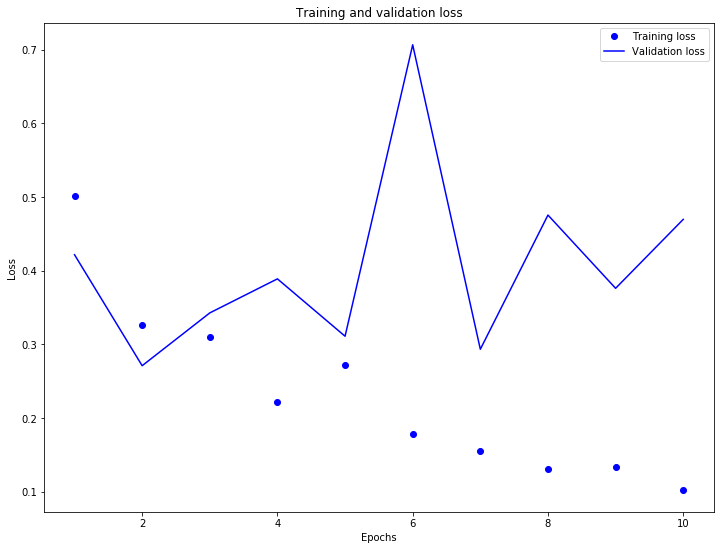

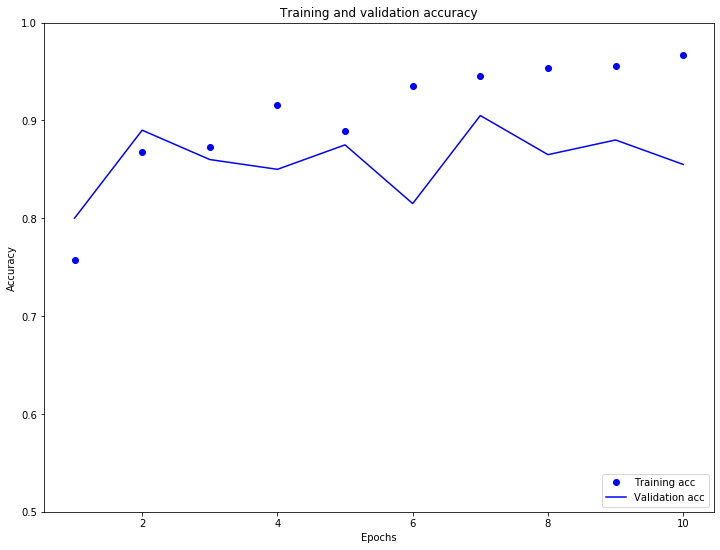

In [30]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [31]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [32]:
encoder = info.features['text'].encoder

In [33]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs-l.tsv', 'w', encoding='utf-8')
out_m = io.open('meta-l.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

## 测试双向LSTM

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
# tfds.disable_progress_bar()
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)
encoder = info.features['text'].encoder
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

embedding_dim=16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim,mask_zero=True),
    layers.Bidirectional(tf.keras.layers.LSTM(32)),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20,verbose=2)

Epoch 1/10


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Reshape_11/_38}}]] [Op:__inference_distributed_function_16087]

Function call stack:
distributed_function
